In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

C:\Users\Bounadja Bilal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  2.40 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:02<00:00,  1.01 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:08<00:00,  2.68s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:09<00:00,  2.35s/ url]


Dataset mnist downloaded and prepared to C:\Users\Bounadja Bilal\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [4]:

def get_adversial_exemple(model, image, label, eps=0.25):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_ex = image + eps*signed_grad    
    adv_ex = tf.clip_by_value(adv_ex, 0, 1)
    return adv_ex

In [5]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)


Epoch 1/5
469/469 [==============================] - 3s 2ms/step - loss: 0.6638 - accuracy: 0.8366
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3599 - accuracy: 0.9030
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3183 - accuracy: 0.9123
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2989 - accuracy: 0.9168
Epoch 5/5
79/79 [==============================] - 1s 8ms/step - loss: 0.2784 - accuracy: 0.9225


[0.2783918082714081, 0.9225000143051147]

In [6]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test) 




Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3934 - accuracy: 0.8888
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1433 - accuracy: 0.9588
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1051 - accuracy: 0.9689
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0827 - accuracy: 0.9753
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9718


[0.0974089726805687, 0.9718000292778015]

In [7]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)


In [10]:
# avaluate shallow_softmax model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_softmax, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_softmax.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )

313/313 [==============================] - 1s 2ms/step
Accuracy on adversial examples: 0.0 with a mean confidence of 0.8821612596511841


In [11]:
# evaluate shallow_maxout model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_maxout, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_maxout.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )


313/313 [==============================] - 0s 2ms/step
Accuracy on adversial examples: 0.002400000113993883 with a mean confidence of 0.9183363318443298


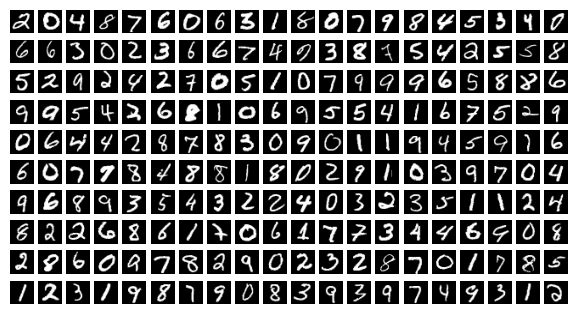

In [12]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()